In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
from omegaconf import OmegaConf
import torchvision
import hydra
from hydra.utils import instantiate

hydra.core.global_hydra.GlobalHydra.instance().clear()
from hydra import compose, initialize
from utils import print_config
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
from torch.utils.data import DataLoader
import torch


def create_lambda_transform(mean, std):
    return torchvision.transforms.Lambda(lambda sample: (sample - mean) / std)


OmegaConf.register_new_resolver("divide", lambda a, b: int(int(a) / b))
OmegaConf.register_new_resolver(
    "compute_lr", lambda base_lr, batch_size: base_lr * (batch_size / 256)
)
OmegaConf.register_new_resolver(
    "decimal_2_percent",
    lambda decimal: int(100 * decimal) if decimal is not None else decimal,
)
OmegaConf.register_new_resolver("convert_str", lambda number: "_" + str(number))
OmegaConf.register_new_resolver("substract_one", lambda number: number - 1)
OmegaConf.register_new_resolver("to_tuple", lambda a, b, c: (a, b, c))
OmegaConf.register_new_resolver("as_tuple", lambda *args: tuple(args))
initialize(version_base="1.2", config_path="../config", job_name="test")

/software/miniconda3/envs/pmae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


hydra.initialize()

In [3]:
def get_data(config):
    data = instantiate(
        config.datamodule,
        data=config.datasets,
        masking=config.masking,
        extra_data=config.extradata,
    )
    data.setup(None)
    return data


def get_loader(data):
    return iter(
        DataLoader(
            data.train_dataset,
            batch_size=data.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=data.num_workers,
            collate_fn=(
                data.collate_fn
                if data.masking.type == "pc"
                and data.masking.strategy
                in ["sampling_pc", "sampling_ratio", "sampling_pc_block"]
                else None
            ),
        )
    )


def unpatchify_flat_mask(mask):
    mask = mask.unsqueeze(-1).repeat(
        1, 1, vit.config.patch_size**2 * 3
    )  # (N, H*W, p*p*3)
    mask = vit.unpatchify(mask)
    return mask


def get_mae_mask(x):
    # TODO: Create a function that returns the mask for the MAE model
    return torch.ones_like(x)


def get_pmae_mask(x):
    # TODO: Create a function that returns the pc mask for the MAE model
    return torch.ones_like(x)

In [4]:
config = compose(config_name="train_defaults.yaml", overrides=["experiment=mae_clevr"])
data = get_data(config)
vit_config = instantiate(config.module_config)
vit = instantiate(config.module, vit_config)

/software/miniconda3/envs/pmae/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/projects/mae/notebooks/../dataset/CLEVRCustomDataset.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expl

# Compute all three different types of masks for a sample batch

In [5]:
loader = get_loader(data)
x, y, mask_batch = next(loader)
mask_batch = mask_batch[:2]
x = x[:2]
sequence = vit.vit.embeddings.patch_embeddings(x, interpolate_pos_encoding=False)
max_layer = nn.MaxPool2d((16, 16), stride=(16, 16))

In [6]:
patched_pca_mask = max_layer(mask_batch[:, :, 0]).float().flatten(2)
batch_size, n_masks, n_patches = patched_pca_mask.shape
max_patches_per_element = patched_pca_mask.sum(dim=-1).max().int()
segmentation_noise = torch.rand_like(patched_pca_mask) * patched_pca_mask
num_patches_per_mask = torch.randint(
    low=0,
    high=max_patches_per_element,
    size=(batch_size, n_masks, 2 * max_patches_per_element),
)
num_patches_per_mask[num_patches_per_mask < 0] = (
    n_patches + num_patches_per_mask[num_patches_per_mask < 0]
)
sorted_order = torch.argsort(segmentation_noise, dim=-1, descending=True)


# orig_order = torch.argsort(sorted_order, dim=-1)
index_to_mask = torch.gather(sorted_order, dim=-1, index=num_patches_per_mask).long()
random_patched_pca_mask = patched_pca_mask.scatter(dim=-1, index=index_to_mask, value=0)

idx_to_keep = sorted_order[:, :, 0, None]
partial_patched_pca_mask = (
    random_patched_pca_mask.scatter(dim=-1, index=idx_to_keep, value=1)
    * patched_pca_mask
)

patched_pca_mask = patched_pca_mask.max(dim=1).values
partial_patched_pca_mask = partial_patched_pca_mask.max(dim=1).values
random_patched_pca_mask = random_patched_pca_mask.max(dim=1).values
mae_mask = get_mae_mask(x)
pmae_mask = get_pmae_mask(x)
final_masks = unpatchify_flat_mask(
    torch.cat([patched_pca_mask, partial_patched_pca_mask, random_patched_pca_mask])
)
final_masks = torch.cat([torch.ones_like(x), final_masks, mae_mask, pmae_mask])

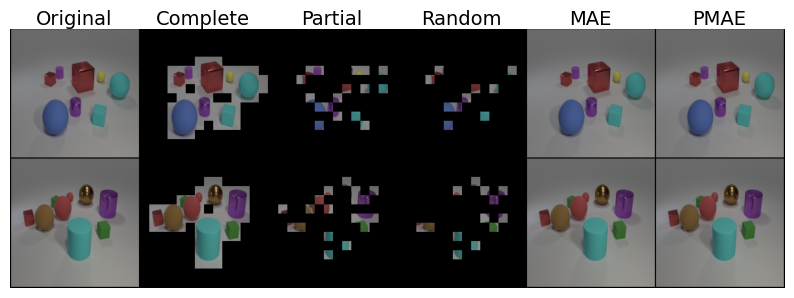

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))


# Remove ticks and labels from both x and y axes
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Optionally, remove the spines (borders) of the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
img = final_masks * torch.cat([x for _ in range(final_masks.shape[0] // x.shape[0])])
# Transpose img
img = img[
    [2 * i for i in range(img.shape[0] // 2)]
    + [2 * i + 1 for i in range(img.shape[0] // 2)]
]
# Make a grid of the images
padding = 2
img = make_grid(img, nrow=final_masks.shape[0] // x.shape[0], padding=padding)
img = img.permute(1, 2, 0).float().cpu().numpy()
ax.imshow(img, vmin=0, vmax=1)
# Add text to the plot at (x, y) coordinates
vertical_offset = -18
img_size = 224
for i, text in enumerate(["Original", "Complete", "Partial", "Random", "MAE", "PMAE"]):
    ax.text(
        img_size // 2 + i * (img_size + padding),
        vertical_offset,
        text,
        fontsize=14,
        ha="center",
        va="center",
    )